# Predicting User Satisfaction from Product Reviews

In this project, based on the reviews of a person about any product, we are predicting the user satisfaction on a scale of 1-5. A model will be created to get the user satisfaction, based on the reviews from any platform for phones.

## DATA SCRAPING

The data has been captured from the BestBuy website using the WebScraper Google Chrome Extension. In the extension, a website-map has to be created to indicate what all elements need to be scraped. And then the extension would itself scrape all the data and save it as a `.csv` file. Our data file is titled "pdsdata1.csv".
The followings item for each user review for phones on the BestBuy website were scraped:
 - __name__	: The name of the user
 - __rating__: The rating given by the user to the product (on a scale of 1 to 5)	
 - __header__: The title of the user review	
 - __review__: The content of the user review		
 - __will_recommend__: A bianry variable containing the user's choice of whether or not he will recomment the product to someone else	
 - __is_helpful__: The number of "thumbs-up" given to the review by other users who think the review was useful.	
 - __is_unhelpful__: The number of "thumbs-down" given to the review by other users who think the review was not useful.
 - __product__: The name of the product i.e the cellphone make and model	
 - __product-price__: Price of the product (This was given as the total price for some phones and monthly cost for others. Therefore this variable could not be used in the model because of the inconsistency)	
 - __average-rating__: The average user rating given to the product in question.	
 - __num_reviews__: The total number of user reviews of the product. 
 
 - __"length_review"__ is a variable created artificially. It denotes the number of characters in the product rview. 

In [2]:
import nltk
from collections import Counter
import pandas as pd
import string
import numpy as np
import sklearn

In [3]:
#Reading DATA FROM CSV FILE 
data = pd.read_csv("pdsdata1.csv", encoding='utf-8', na_filter=False)

## DATA CLEANING

### REMOVING PUNCTUATION, CONVERTING TO LOWERCASE AND LEMMATIZING REVIEWS
The "process" function takes the text, converts it to lowercase and then removes all the punctuation and apostrophes from the review data. 
The data is then split into words, each of which is lemmatized using the nltk.stem.wordnet.WordNetLemmatizer().
The function returns a list of tokenized text. 

In [4]:
from nltk.tokenize import RegexpTokenizer
import re

def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    lemmas=[]
    text=text.lower()
    text = text.replace("'s","")
    text = text.replace("'","")
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text=text.translate(translator)
    tokens = nltk.word_tokenize(text)
    for t in tokens:
        try:
            lemmas.append(lemmatizer.lemmatize(t))
        except:
            lemmas=lemmas
    lemmas=[str(l) for l in lemmas]   
    return lemmas

### COUNTING UPPER CASE WORDS
The "process_all" function has two functions:
    1) It applies the "process" function described above, to the dataset.
    2) It generates a new feature in the dataset, namely the 'uppercase_words_count'. This is merely a count of the number of words in each review that are typed in uppercase. We thought that text typed in uppercase usually depicts stronger feelings, so there might be an interaction effect of this feature on the relationship between reviews and rating.  
    

In [5]:
def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()): 
    uppercount=[]

    for rev in df['review']:
        count=0
        for word in rev.split():
            if word.isupper():
                count+=1
        uppercount.append(count) 
    df['review']=df['review'].apply(process,lemmatizer)
    df['uppercase_words_count']=uppercount
    return df

processed_reviews = process_all(data)

### GETTING A LIST OF RARE WORDS
The "get_rare_words" function prepares a list of rare words (words occuring less than twice in the entire text body). This list of rare words will be useful later on when added to 'stopwords' for removal during TFIDF vectorization.

In [6]:
def get_rare_words(processed_reviews):
    wd_list=[]
    for i in processed_reviews['review']:
        for j in i:
            wd_list.append(j)
    ctr=Counter(wd_list)
    rarewds=[]
    for a in ctr:
        if ctr[a]<2:
            rarewds.append(a)
    rarewds.sort()
    return rarewds

rare_words = get_rare_words(processed_reviews)
processed_reviews['review'] = processed_reviews['review'].apply(lambda x: str(" ".join(x)))

In [7]:
#change column datatypes
processed_reviews['is_helpful']=processed_reviews['length_review'].astype('int64')
processed_reviews['is_unhelpful']=processed_reviews['length_review'].astype('int64')
print(processed_reviews.dtypes)

web-scraper-order         object
web-scraper-start-url     object
Name                      object
rating                     int64
header                    object
review                    object
length_review              int64
will_recommend             int64
is_helpful                 int64
is_unhelpful               int64
product                   object
product-price             object
average-rating           float64
num_reviews                int64
uppercase_words_count      int64
dtype: object


## DATA VISUALISATION

For the visualisation of the textual reviews, a wordcloud was created. The reviews scraped and cleaned were grouped by the ratings i.e. 1-5 and then the frequency wordcloud has been formed. The word cloud has been created using the WordCount package and displayed with the help of matplotlib. Following is the code for grouping the reviews and an example of the words for the reviews with a rating of 5.

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

groups = processed_reviews.groupby('rating')
groups = processed_reviews.groupby('rating')['review'].apply(' '.join).reset_index()
words5 = groups['review'][5].split(" ")
text = ' '.join(words5)

After the text has been created, a wordcloud is generated which is then displayed.

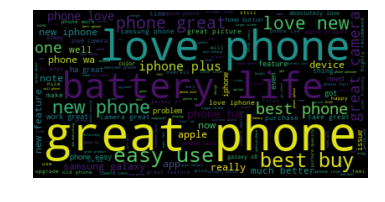

In [9]:
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## DEVELOPING THE CLASSIFIER

The TD-IDF Vectorizer is used to get vector of TD-IDF scores of all the words in the cleaned reviews. The words are then split in to the 80:20 ratio as train and test dataset. Then, the model is trained using these TF-IDF scores and the Random Forest Classifier. 

In [10]:
from sklearn.model_selection import train_test_split
import sklearn.ensemble as sk
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle

The different attributes associated with the RandomForest Classifier were also tried for getting the better accuracy and prevent overfitting of the model. Following are some of the attributes tried :
 - min_samples_split : This parameter indicates how many minimum number of samples are needed so that an additional split can take place. After trying various combinations, it turns out that a minimum split of 15 gives better results.
 - max_depth : This parameter indicates the maimum depth upto which the tree can grow. The default version works here because, there are so many words that any restriction on the depth won't classify properly.
 - n_estimators : This parameter indicated the number of trees that have to be formed to give the result. The default version has 10 trees. But, when the number of trees is increased to around 50, there is a better prediction and also an increase in the precision and recall score.
 
There are various other parameters that can be used. After trying various combinations, other parameters didn't give very satisfactory results.

In [11]:
stopwords=nltk.corpus.stopwords.words('english')
tfidf = TfidfVectorizer(stop_words=stopwords+rare_words)
features = tfidf.fit_transform(processed_reviews['review'])
categories = processed_reviews['rating']
x, x_test, y, y_test = train_test_split(features,categories,test_size=0.2,train_size=0.8, random_state = 0)
clf1 = sk.RandomForestClassifier(n_estimators=50, min_samples_split=15)
clf1.fit(x, y)
predicted = clf1.predict(x_test)

## EVALUATING THE CLASSIFIER

This model gave an accuracy of 80.5%. Also, a classification report has been found out from the model developed. 

The precision score i.e. fraction of correct positive labels detected over all the instances detected positive comes to around 80% on an average, which shows that the model detects positive when it is actually positive 4/5th of the times.

The recall score i.e. fraction of correct positive labels detected over all the instances detected correctly is around 81% on an average.

In [12]:
acc = sklearn.metrics.accuracy_score(y_test, predicted)
print("Accuracy :"+str(acc))
print("Classification Report:")
print(sklearn.metrics.classification_report(y_test, predicted))

Accuracy :0.805252309337
Classification Report:
             precision    recall  f1-score   support

          1       1.00      0.03      0.06       101
          2       1.00      0.06      0.11       107
          3       1.00      0.06      0.12       307
          4       0.73      0.07      0.13      2190
          5       0.81      1.00      0.89     10394

avg / total       0.80      0.81      0.73     13099



### APPLICATION OF THE MODEL
The model basically gives us a way to quantify user reviews and generate meaningful information and insights from them.

As we can see, the model gives a pretty good accuracy on test data. The model can be used for sentiment analysis on social media, techblogs an other websites. By scraping user reviews, opinion pieces and comments and feeding them into the model, we can track the user satisfaction score for different cellphones.

This can be used to compare the popularity of different models on different online media platforms, which could be representing specific segments of the population. Further, the data collected can be used to monitor trends in popularity of cellphones over time as new models and features are launched into the market. Market dynamics can be observed as people express their opinions on different makes and models.

The model has been applied to real world data collected from Amazon cell phone reviews and  tech blogs like Tech Crunch. The results obtained seem believable. In order to evaluate the performance of our model on real world data, first the TFIDF vectors of the whole corpus of words in the dataset has to be saved in a pickle file.

In [13]:
corpus = processed_reviews['review']
vectorizer = TfidfVectorizer(stop_words=stopwords+rare_words)
vec_train = vectorizer.fit_transform(corpus)
#Save vectorizer.vocabulary_
pickle.dump(vectorizer.vocabulary_,open("feature.pkl","wb"))

The test data is vectorized using TFIDFVectorizer along with the trained data vocabulary pickel file loaded into it. Then the prediction can be made on the TFIDF vectors of the test data words using model trained above.

In [14]:
review_test=['So so,So far I like it but want to contact samsung on freezing issues.','I hate this phone. Not user friendly. very low volume. speaker doesnt work. Not useful. not good. bad','I love this phone! I upgraded from an iPhone 7. I would have to say this is one of the best iPhones I have ever had, and I upgrade every year. The camera is bomb.com. The portrait mode is pretty cool, and even the front facing camera seems to be more clear, (less grainy). The screen is brighter, the true tone display really makes a difference on the screen. This phone is way faster than my 7. The speakers are louder also. This phone has a lot of the same specs as the upcoming iPhone x, but still feels like an iPhone. I was going to get the x, but decided that I would wait until the next generation of that phone. If you can get most of the same specs as iPhone x for less, combined with the familiarity and reliability of the iPhone we are used to, why not do that?', 'I love the phone']
testdf = pd.DataFrame(columns=['review'])
testdf['review'] = review_test
process_testdf = process_all(testdf)
process_testdf['review'] = process_testdf['review'].apply(lambda x: str(" ".join(x)))
tfidf1 = TfidfVectorizer(vocabulary=pickle.load(open("feature.pkl", "rb")))

features1 = tfidf1.fit_transform(process_testdf['review'])
predictedd = clf1.predict(features1)
print(predictedd)

[5 4 5 5]


## EXTENDING THE MODEL
Even though the model predicts with reasonable accuracy, it might be a good idea to incorporate the other features we got from scraping BestBuy reviews into the model to see if they can increase the predictive power. Even though this section will not be generalizable to reviews taken from the social media or in fact any other source that is not BestBuy, it will give us a good idea of how much better we can model the relationship between a user's words and his satisfaction level with the product, given a variety of other variables.

### GENERATING DUMMY VARIABLES FOR THE PRODUCT MANUFACTURER
A variable describing the make of the phone might have an interaction effect on the relationship between reviews and ratings. This is because different companies e.g Apple and Samsung cater to a different segment of the population. 
The "product" feature in the data is broken down using the "splits" function and the brand name is extracted. 
Dummy variables are then generated to include the brand as a categorical variable in the model. 

Here, the product names from the data collected is split for the first word which is the company we are considering. Then, the dummies are created i.e. new columns are created for each company with a value 1 if the particular row belongs to that product else 0. This is done using the pandas `get_dummies()`.

In [15]:
def strips(s):
    return s.strip().split('-')[0].strip()

processed_reviews['product']=processed_reviews['product'].apply(strips)
dum=pd.get_dummies(processed_reviews['product'])
dum.drop(['null'],axis=1)

processed_reviews = pd.concat([processed_reviews, dum], axis=1)

### FINDING BEST FEATURES FROM THE DATA 

There are various features in the scraped data available which may be useful for prediction of the user satisfaction. Hence, the features which affect the rating most can be found out. 

First of all, the features are combined using the DataFrameMapper class of the `sklearn-pandas` library. This is basically used when there are various transformations that need to be applied, for example: TFIDF transformation to the text data.  

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn_pandas import DataFrameMapper, cross_val_score
import sklearn.ensemble as sk
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier


stopwords=nltk.corpus.stopwords.words('english')
stopwords+=rare_words
mapper = DataFrameMapper([
     ('length_review', None),
    ('will_recommend',None),
     ('is_helpful',None),
      ('is_unhelpful',None),
    ('Apple',None),
    ('Samsung',None),
    ('Sony',None),
     ('average-rating',None),
    ('num_reviews',None),
    ('uppercase_words_count',None),
 ])

features = mapper.fit_transform(processed_reviews)
categories = processed_reviews['rating']
x, x_test, y, y_test = train_test_split(features,categories,test_size=0.2,train_size=0.8, random_state = 0)

Now, using the feature\_importances\_  attribute of the classifier, we get the probabilities of the importance of the features. Then to select the best model i.e. which features to include based on the probabilities is done by the SelectFromModel library of the sklearn package. The get_support() function gives a boolean indication of whether to choose that fetaure or no.

In [17]:
clf2=sk.RandomForestClassifier(random_state=0)

clf2.fit(x, y)
print(clf2.feature_importances_ )
model = SelectFromModel(clf2, prefit=True)

predicted = model.transform(x_test)

model.get_support()

[ 0.15636468  0.11966104  0.15648453  0.15353238  0.00930863  0.00861996
  0.00151556  0.02677058  0.21397392  0.15376871]


array([ True,  True,  True,  True, False, False, False, False,  True,  True], dtype=bool)

Based on the output from the previous step, a new mapper is created with the tfidf features as well as the new features selected and again a RandomForest classifier is built.

In [18]:
mapper2 = DataFrameMapper([
     ('review', TfidfVectorizer(stop_words=stopwords+rare_words)),
     ('length_review', None),
     ('will_recommend', None),
     ('header', TfidfVectorizer(stop_words=stopwords)),
     ('is_helpful', None),
     ('is_unhelpful', None),
     ('num_reviews', None),
     ('uppercase_words_count', None)
 ])


features = mapper2.fit_transform(processed_reviews)
categories = processed_reviews['rating']
x, x_test, y, y_test = train_test_split(features,categories,test_size=0.2,train_size=0.8, random_state = 0)


In [21]:
clf3 = sk.RandomForestClassifier(n_estimators=20)
clf3.fit(x, y)

predicted = clf3.predict(x_test)


The new classifier created gives an accuracy of 82% which is slightly more then what received earlier but is very comparable.

In [23]:
print(predicted)
acc = sklearn.metrics.accuracy_score(y_test, predicted)
print(acc)

[5 5 5 ..., 5 5 5]
0.820520650431


## CONCLUSION

 - The extensions proved that adding features doesn’t improve accuracy too much.
 - Thus, for predicting user satisfaction from customer reviews, our first model proved to be good enough.
